In [1]:
import sys, os
from os.path import split, join
base_dir = split(os.getcwd())[0]
if base_dir not in sys.path:
    sys.path.append(base_dir)
from os.path import join
import pandas as pd
from utilities import basic, utils, mri_stats, stats
from stats_tools import vis as svis
import numpy as np
import pickle
from access_sif_data import load_data_tools as ld
import seaborn as sns
#import chart_studio.plotly as py
#import plotly.express as px
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#import cufflinks as cf
#init_notebook_mode(connected=True)
#cf.go_offline()

import matplotlib.pyplot as plt
from datetime import datetime as dt
%matplotlib inline
plt.rcParams["figure.dpi"] = 40
plt.style.use('ggplot')
import importlib
importlib.reload(svis)

<module 'stats_tools.vis' from 'c:\\Users\\kiril\\Thesis\\CoBra\\cobra\\stats_tools\\vis.py'>

## AcquisitionContrast Column can be dropped

In [2]:
fig_dir = join(base_dir, 'figs')
table_dir = join(base_dir, 'data/tables')
# dfc = utils.load_scan_csv(join(table_dir, 'scan_tables','scan_after_sq_pred_dst.csv'))
with open(join(table_dir, 'scan_tables','scan_after_sq_pred_dst.pkl'), 'rb') as f:
    dfc = pickle.load(f)

## Number of slices

In [19]:
with open("C:\\Users\\kiril\\Thesis\\CoBra\\cobra\\t1_long\\nos.pkl", 'rb') as f:
    nos_dic = pickle.load(f)

In [23]:
dfc.NumberOfSlices = dfc.NumberOfSlices.fillna(dfc.SeriesInstanceUID.map(nos_dic))

In [4]:
#keys = dfc.keys()
TE_k = 'EchoTime'
TR_k = 'RepetitionTime'
TI_k = 'InversionTime'
FA_k = 'FlipAngle'
SD_k = 'SeriesDescription'
PID_k = 'PatientID'
time_k = 'InstanceCreationTime'
date_k = 'InstanceCreationDate'
DT_k = 'DateTime'
SID_k = 'SeriesInstanceUID'
SS_k = 'ScanningSequence'
SV_k = 'SequenceVariant'
SN_k = 'SequenceName'
SO_k = 'ScanOptions'
ETL_k = 'EchoTrainLength'
MFS_k = 'MagneticFieldStrength'

<AxesSubplot:>

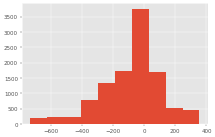

In [36]:
dfc.days_since_test.hist()

## Number of positive and negative patients by modality

In [41]:
df_pos = dfc[dfc.days_since_test>=-3]
posp_count = {}
negp_count = {}
for mod in df_pos.Sequence.unique():
    df_pos.Sequence

C:\Users\kiril\.conda\envs\cobra\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

Text(-0.1, 24381, '24081')

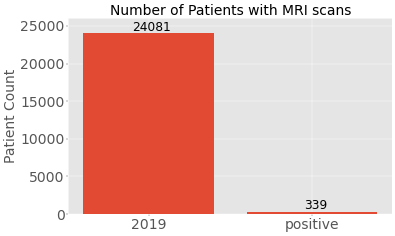

In [25]:
labels = ['2019', 'positive']
pos_mask = dfc.Positive==1
pos_pat_count = dfc[PID_k][pos_mask].nunique()
neg_pat_count = dfc[PID_k][~pos_mask].nunique()
counts = np.array([neg_pat_count, pos_pat_count])
kwargs={'xlabel':'', 'show':False, 'yrange':(0,26000),
        'ylabel':'Patient Count', 'title':'Number of Patients with MRI scans'}
fig, ax = svis.bar(labels, counts, kwargs=kwargs)
ax.text(1-.05, pos_pat_count+300, pos_pat_count, fontsize=22)
ax.text(0-.1, neg_pat_count+300, neg_pat_count, fontsize=22)

# Acquisition date

## For each volume

In [14]:
(dfc.days_since_test>0).sum()

2494

In [20]:
dfc.InstanceCreationDate.isna().sum()

54325

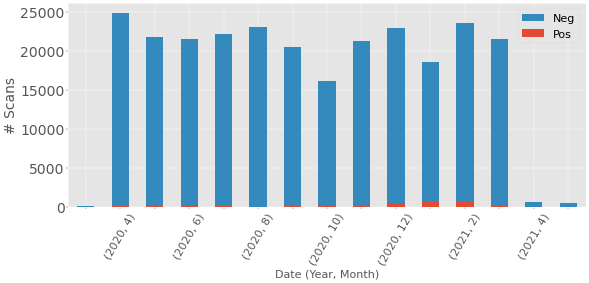

In [9]:
#Now remove all the missing dates
dfc["InstanceCreationDate"] = dfc["InstanceCreationDate"].astype("datetime64")
df_p = dfc[dfc.Positive==1]
df_n = dfc[dfc.Positive==0]

fig, ax = svis.plot_decorator(df_n.groupby([df_n["InstanceCreationDate"].dt.year, \
    df_n["InstanceCreationDate"].dt.month]).Rows.count().plot, 
    figsize=(15,8),
    plot_func_kwargs={'kind':'bar','label':'Neg', 
        'color':svis.Color_palette(0)[1],} ,
    kwargs={'xtickparams_rot':80, 'ylabel':'# Scans',
    })
ax = df_p.groupby([df_p["InstanceCreationDate"].dt.year, \
    df_p["InstanceCreationDate"].dt.month]).Rows.count().plot(kind="bar", 
    color=svis.Color_palette(0)[0], ax=ax, label='Pos')
ax.tick_params(axis='x', which='major', labelsize=20, rotation=70)
ax.set_xlabel('Date (Year, Month)', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='x', which='major', rotation=60)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
fig.savefig(join(fig_dir, 'basic_stats','year_month_volumes'),dpi=100)

## For each study

In [15]:
# df_sorted = dfc.groupby('PatientID').apply(
        # lambda x: (x.sort_values(by=['DateTime'], ascending=True)))
# df_studies = mri_stats.get_studies_df(df_sorted)
# df_studies.to_csv(f"{table_dir}/studies_clean.csv", index=False, header=True)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [16]:
df_studies = pd.read_csv(f"{table_dir}/studies_clean.csv", 
    converters={'DateTimeStart':utils.date_time_converter})
pos_mask = df_studies.PatientID.isin(df_p.PatientID.unique())
df_studies_p = df_studies[pos_mask]
df_studies_n = df_studies[~pos_mask] 

## Studies over time

In [17]:
df_studies_n = df_studies[df_studies.PatientID.isin(dfc[dfc.Positive==0].PatientID)]
df_studies_p = df_studies[df_studies.PatientID.isin(dfc[dfc.Positive==1].PatientID)]

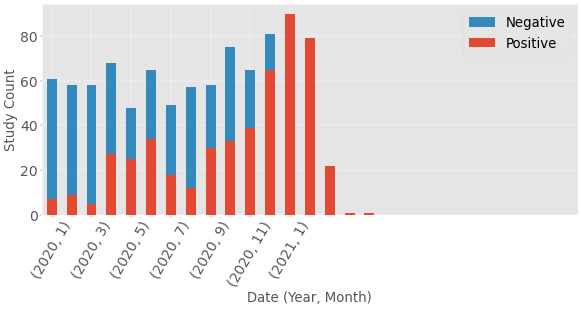

In [18]:
fig, ax = svis.plot_decorator(df_studies_n.groupby([df_studies_n["DateTimeStart"].dt.year, \
    df_studies_n["DateTimeStart"].dt.month]).DateTimeStart.count().plot, 
    figsize=(15,8),
    plot_func_kwargs={'kind':'bar','label':'Negative', 
        'color':svis.Color_palette(0)[1],} ,
    kwargs={'xtickparams_rot':60, 'ylabel':'Study Count',
        'ylabel_fs':24,
    })
ax = df_studies_p.groupby([df_studies_p["DateTimeStart"].dt.year, \
    df_studies_p["DateTimeStart"].dt.month]).DateTimeStart.count().plot(kind="bar", 
    color=svis.Color_palette(0)[0], ax=ax, label='Positive')
ax.tick_params(axis='x', which='major', rotation=60)
ax.set_xlabel('Date (Year, Month)', fontsize=24)
ax.legend(fontsize=24)
x_ticks = ax.get_xticks()

# Set xtick locations to the values of the array `x_ticks`
ax.set_xticks(x_ticks[:-3:2])

ax.set_xlim(-.5, 26.5)
fig.savefig(join(fig_dir, 'basic_stats','year_month_studies_no_other'),dpi=100)